In [1]:
import os

# os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "true"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.90"
# os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

import jax
jax.config.update("jax_enable_x64", False)
jax.config.update("jax_platform_name", "gpu")

import functools
from typing import Callable

import tqdm
import equinox as eqx

import jax.numpy as jnp
import numpy as np
import optax
from jaxtyping import Array, PyTree, Int, Float, Complex, PRNGKeyArray

import netket as nk
from netket.operator import FermionOperator2ndJax
from netket.operator.fermion import destroy as c
from netket.operator.fermion import create as cdag
from netket.operator.fermion import number as nc

from netket.experimental.driver import VMC_SRt
from netket.jax import logdet_cmplx

import matplotlib.pyplot as plt

key = jax.random.key(42)

## Construct Hilbert spaces and Hamiltonian operator
- Hilbertspace
\begin{equation}
    \mathcal H = \operatorname{span}\{\ket{n}:n \in \mathcal L(L_x, L_y, ...)\},\quad F_{-} (\mathcal H) = \bigoplus_{n=0}^\infty S_{-}\mathcal H^{\otimes n}
\end{equation}
Where $\mathcal L(L_x, L_y, ...)$ is square lattice with lengths $L_x, L_y, ...$.


- Hamiltonian operator
\begin{equation}
    H=-t\sum_{\braket{\mathbf r, \mathbf r'}, \sigma} [c_{\sigma}^\dagger(\mathbf r')c_{\sigma}(\mathbf r) + c_{\sigma}^\dagger(\mathbf r)c_{\sigma}(\mathbf r')] + U\sum_{\mathbf r} n_\uparrow (\mathbf r) n_\downarrow (\mathbf r)
\end{equation}


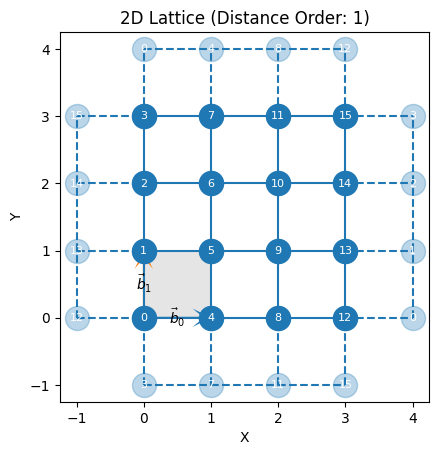

<Axes: title={'center': '2D Lattice (Distance Order: 1)'}, xlabel='X', ylabel='Y'>

In [2]:
def construct_system(t: float, U: float, N: int, L: list[int], pbc=True) -> tuple[nk.hilbert.SpinOrbitalFermions, FermionOperator2ndJax]:
    hi = nk.hilbert.SpinOrbitalFermions(N, s=1/2, n_fermions=N)
    H = FermionOperator2ndJax(hi)

    graph = nk.graph.Grid(L, pbc=pbc)
    for (r1, r2) in graph.edges():
        for s in [-1, 1]:
            H += -t * (cdag(hi, r1, s) * c(hi, r2, s) + cdag(hi, r2, s) * c(hi, r1, s))

    for r in graph.nodes():
        H += U * nc(hi, r, -1) * nc(hi, r, 1)

    return hi, H

t = 1.0
U = 8.0
N = 14
L = [4, 4]
PBC = True

graph = nk.graph.Grid(L, pbc=PBC)
graph_extended = nk.graph.disjoint_union(graph, graph)

graph.draw()

In [3]:
hi = nk.hilbert.SpinOrbitalFermions(graph.n_nodes, s=1/2, n_fermions=N)

H = FermionOperator2ndJax(hi)
for (r1, r2) in graph.edges():
    for s in [-1, 1]:
        H += -t * (cdag(hi, r1, s) * c(hi, r2, s) + cdag(hi, r2, s) * c(hi, r1, s))

for r in graph.nodes():
    H += U * nc(hi, r, -1) * nc(hi, r, 1)

## Exact Diagonalization

As a reference

In [4]:
# sp_h = H.to_numba_operator().to_sparse()

In [5]:
# from scipy.sparse.linalg import eigsh

# eig_vals, eig_vecs = eigsh(sp_h, k=2, which="SA")

# E_gs = eig_vals[0]

# print("Exact ground state energy:", E_gs)
E_gs = -0.74 * 16

## Mean-Field Slater Determinant

\begin{equation}
    \ket{\Phi_s}=\prod_{\alpha=1}^{N_{\mathrm f}}\phi_\alpha^\dagger\ket{0}
\end{equation}

Where $\ket{0}$ is the vacuum state and the single-particle orbitals are created by the operators $\phi_\alpha^\dagger$. In turn, these creation operators are, in general, a linear combination of the original creation operators:
\begin{equation}
    \phi_\alpha^\dagger =\sum_{i} M_{\alpha, i}c_i^\dagger
\end{equation}
The rectangular $(N\times N_{\mathrm f})$ matrix $M$ constitutes a set of free variational parameters (Where $N$ is the number of orbitals and $N_{\mathrm f}$ the number of fermions).

It can be shown that the amplitudes of the wave function in the computational basis $\ket{n_1, ..., n_N}$ are determinants:
\begin{equation}
    \braket{n_1, ..., n_N|\Phi_{s}} = \det\{A(n)\}
\end{equation}
where the $N_{\mathrm f}\times N_{\mathrm f}$ matrix is
\begin{equation}
    A(n)_{\alpha,\beta} = M_{R_\alpha(\mathbf n), \beta},
\end{equation}
where $R_\alpha(\mathbf n)$ denotes the index of the $\alpha$-th occupied site (non-zero $n_i$) in $\mathbf n=(n_1, ..., n_N)$. This can also be interepted as selecting $N_{\mathrm f}$ rows of the matrix $M$ in corresponding to the $N_{\mathrm f}$ occupied orbitals. For more details see Chapter 5 of Reference [1].

To write down this variational amplitudes, we start by defining a convenience function to compute the logarithm of the determinant of a matrix, in the complex domain, and using jax:

In [6]:
@jax.jit
def nkstate_to_indexseq(
    state,
) -> jnp.ndarray:
    return jnp.nonzero(state, size=hi.n_fermions)

def count_parameters(model):
    leaves = jax.tree.leaves(model)
    return sum(x.size for x in leaves if isinstance(x, jnp.ndarray))

class BatchWrapper(eqx.Module):
    submodule: eqx.Module

    def __init__(self, submodule):
        self.submodule = submodule

    def __call__(self, batch, **kwargs):
        outputs = jax.vmap(self.submodule)(batch)
        return outputs

### Simplest Slater Determinant

In [7]:
class LogSlaterDeterminant(eqx.Module):
    embedding: eqx.nn.Embedding

    def __init__(
        self,
        hilbert: nk.hilbert.SpinOrbitalFermions,
        *,
        key: PRNGKeyArray
    ):
        self.embedding = eqx.nn.Embedding(hilbert.size, hilbert.n_fermions, key=key)

    def __call__(
        self,
        state: Int[Array, "hilb_size"]
    ) -> Complex[Array, ""]:
        indices = nkstate_to_indexseq(state)[0]
        A = jax.vmap(self.embedding)(indices)
        return logdet_cmplx(A)

In [8]:
key, subkey = jax.random.split(key)
model = LogSlaterDeterminant(hi, key=subkey)
ma = BatchWrapper(
    model
)
sa = nk.sampler.MetropolisFermionHop(hi, graph=graph_extended)
count_parameters(model)

448

In [9]:
vstate = nk.vqs.MCState(sa, ma, n_samples=2**12, n_discard_per_chain=8)

In [10]:
vstate.samples.shape

(16, 256, 32)

In [11]:
vstate.samples[0,0]

Array([1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 0], dtype=int8)

In [12]:
# Define the optimizer
op = nk.optimizer.Sgd(learning_rate=0.01)

# Define a preconditioner
preconditioner = nk.optimizer.SR(diag_shift=0.01)

# Create the VMC (Variational Monte Carlo) driver
gs = nk.VMC(H, op, variational_state=vstate, preconditioner=preconditioner)

In [13]:
# Construct the logger to visualize the data later on
slater_log=nk.logging.RuntimeLog()

# Run the optimization for 300 iterations
gs.run(n_iter=300, out=slater_log)

  0%|          | 0/300 [00:00<?, ?it/s]

(RuntimeLog():
  keys = ['acceptance', 'Energy'],)

In [14]:
sd_energy = vstate.expect(H)
error = abs((sd_energy.mean - E_gs) / E_gs)

print(f"Optimized energy : {sd_energy}")
print(f"Relative error   : {error}")

Optimized energy : -8.855-0.000j ± 0.038 [σ²=4.315, R̂=1.0049]
Relative error   : 0.252114199223026


### Neural Jastrow

In [15]:
class LogNeuralJastrowSlater(eqx.Module):
    embedding: eqx.nn.Embedding
    jastrow_linear: eqx.nn.Linear

    def __init__(
        self,
        hilbert: nk.hilbert.SpinOrbitalFermions,
        hidden_size: int,
        *,
        key: PRNGKeyArray
    ):
        embedding_key, jastrow_key = jax.random.split(key, 2)
        self.embedding = eqx.nn.Embedding(hilbert.size, hilbert.n_fermions, key=embedding_key)
        self.jastrow_linear = eqx.nn.Linear(
            hilbert.size,
            hidden_size,
            key=jastrow_key
        )

    def __call__(
        self,
        state: Int[Array, "hilb_size"]
    ) -> Complex[Array, ""]:
        indices = nkstate_to_indexseq(state)[0]
        A = jax.vmap(self.embedding)(indices)
        J = self.jastrow_linear(state)
        J = jax.nn.tanh(J)
        J = jnp.sum(J)

        return logdet_cmplx(A) + J

In [16]:
key, subkey = jax.random.split(key)
model = LogNeuralJastrowSlater(
    hilbert=hi,
    hidden_size=hi.size,
    key=subkey
)
ma = BatchWrapper(
    model
)
sa = nk.sampler.MetropolisFermionHop(hi, graph=graph_extended)
vstate = nk.vqs.MCState(sa, ma, n_samples=2**12, n_discard_per_chain=8)
count_parameters(model)

1504

In [17]:
# Define the optimizer
op = nk.optimizer.Sgd(learning_rate=0.01)

# Define a preconditioner
preconditioner = nk.optimizer.SR(diag_shift=0.01)

# Create the VMC (Variational Monte Carlo) driver
gs = nk.VMC(H, op, variational_state=vstate, preconditioner=preconditioner)

In [18]:
 # Construct the logger to visualize the data later on
nj_log=nk.logging.RuntimeLog()

# Run the optimization for 300 iterations
gs.run(n_iter=300, out=nj_log)

  0%|          | 0/300 [00:00<?, ?it/s]

(RuntimeLog():
  keys = ['acceptance', 'Energy'],)

In [19]:
sd_energy = vstate.expect(H)
error = abs((sd_energy.mean - E_gs) / E_gs)

print(f"Optimized energy : {sd_energy}")
print(f"Relative error   : {error}")

Optimized energy : -10.614-0.000j ± 0.036 [σ²=5.000, R̂=1.0023]
Relative error   : 0.10355610792064988


### Self-Attention Ansatz

In [31]:
class TransformerLayer(eqx.Module):
    attention: eqx.nn.MultiheadAttention
    up_proj: eqx.nn.Linear
    down_proj: eqx.nn.Linear
    ln1: eqx.nn.LayerNorm
    ln2: eqx.nn.LayerNorm
    activation: Callable

    def __init__(
        self,
        hidden_size: int,
        attention_size: int,
        num_head: int,
        intermediate_size: int,
        activation: Callable,
        *,
        key
    ):
        attention_key, up_proj_key, down_proj_key = jax.random.split(key, 3)
        self.attention = eqx.nn.MultiheadAttention(
            num_head,
            hidden_size,
            hidden_size,
            hidden_size,
            hidden_size,
            attention_size,
            attention_size,
            key=attention_key
        )
        self.up_proj = eqx.nn.Linear(
            hidden_size,
            intermediate_size,
            key=up_proj_key
        )
        self.down_proj = eqx.nn.Linear(
            intermediate_size,
            hidden_size,
            key=down_proj_key
        )
        self.ln1 = eqx.nn.LayerNorm(hidden_size)
        self.ln2 = eqx.nn.LayerNorm(hidden_size)
        self.activation = activation

    def __call__(
        self,
        x: Float[Array, "n h"]
    ):
        atten_out = self.attention(x, x, x)
        ff_in = jax.vmap(self.ln1)(atten_out + x)
        up_projected = jax.vmap(self.up_proj)(ff_in)
        up_projected = self.activation(up_projected)
        down_projected = jax.vmap(self.down_proj)(up_projected)
        return jax.vmap(self.ln2)(ff_in + down_projected)

class AttentionWFN(eqx.Module):
    embedding: eqx.nn.Embedding
    ln: eqx.nn.LayerNorm
    layers: tuple[TransformerLayer]
    projector: eqx.nn.Linear
    use_complex: bool=eqx.field(static=True)

    def __init__(
        self,
        hilbert: nk.hilbert.SpinOrbitalFermions,
        num_layers: int,
        hidden_size: int,
        attention_size: int,
        num_head: int,
        intermediate_size: int,
        activation: jax.nn.gelu,
        *,
        use_complex: bool=False,
        key: PRNGKeyArray
    ):
        embedding_key, attention_key, proj_key = jax.random.split(key, 3)
        self.embedding = eqx.nn.Embedding(hilbert.size, hidden_size, key=embedding_key)
        self.ln = eqx.nn.LayerNorm(hidden_size)
        attention_keys = jax.random.split(attention_key, num_layers)
        self.layers = tuple(
            TransformerLayer(
                hidden_size,
                attention_size,
                num_head,
                intermediate_size,
                activation,
                key=subkey
            )
            for subkey in attention_keys
        )
        out_size = 2 * hilbert.n_fermions if use_complex else hilbert.n_fermions
        self.projector = eqx.nn.Linear(hidden_size, out_size, key=proj_key)
        self.use_complex = use_complex


    def __call__(
        self,
        state: Int[Array, "hilb_size"]
    ) -> Complex[Array, ""]:
        indices = nkstate_to_indexseq(state)[0]
        embedded = jax.vmap(self.embedding)(indices) # (n_fermions, hidden_size)
        embedded = jax.vmap(self.ln)(embedded)
        for layer in self.layers:
            embedded = layer(embedded)
        projected = jax.vmap(self.projector)(embedded)
        if self.use_complex:
            real, imag = jnp.split(projected, 2, axis=1)
            projected = jax.lax.complex(real, imag)
        return logdet_cmplx(projected)

In [ ]:
key, subkey = jax.random.split(key)
model = AttentionWFN(
    hilbert=hi,
    num_layers=4,
    hidden_size=32,
    attention_size=32,
    num_head=1,
    intermediate_size=32,
    activation=jax.nn.mish,
    use_complex=False,
    key=subkey
)
ma = BatchWrapper(
    model
)
sa = nk.sampler.MetropolisFermionHop(hi, graph=graph_extended)
vstate = nk.vqs.MCState(sa, ma, n_samples=2**12, n_discard_per_chain=8)
count_parameters(model)

26894

In [36]:
    # op = nk.optimizer.Adam(learning_rate=0.001)
    # gs = nk.VMC(H, op, variational_state=vstate)

    # Define the optimizer
    op = nk.optimizer.Sgd(learning_rate=0.01)

    # Define a preconditioner
    preconditioner = nk.optimizer.SR(diag_shift=0.01)

    # Create the VMC (Variational Monte Carlo) driver
    gs = nk.VMC(H, op, variational_state=vstate, preconditioner=preconditioner)
    # gs = VMC_SRt(H, op, variational_state=vstate, diag_shift=0.004)

In [37]:
# Construct the logger to visualize the data later on
atten_log=nk.logging.RuntimeLog()

# Run the optimization for 300 iterations
gs.run(n_iter=300, out=atten_log)

  0%|          | 0/300 [00:00<?, ?it/s]

2025-05-30 22:30:22.628065: W external/xla/xla/hlo/transforms/simplifiers/hlo_rematerialization.cc:3022] Can't reduce memory use below 13.41GiB (14401100525 bytes) by rematerialization; only reduced to 17.78GiB (19094360616 bytes), down from 15.53GiB (16675853064 bytes) originally
2025-05-30 22:30:51.754205: W external/xla/xla/tsl/framework/bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 17.83GiB (rounded to 19148494080)requested by op 
2025-05-30 22:30:51.754342: W external/xla/xla/tsl/framework/bfc_allocator.cc:512] *___________________________________________________________________________________________________
E0530 22:30:51.754368     629 pjrt_stream_executor_client.cc:2917] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 19148494032 bytes. [tf-allocator-allocation-error='']


XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 19148494032 bytes.

In [ ]:
sd_energy = vstate.expect(H)
error = abs((sd_energy.mean - E_gs) / E_gs)

print(f"Optimized energy : {sd_energy}")
print(f"Relative error   : {error}")

Optimized energy : -10.986+0.000j ± 0.057 [σ²=5.583, R̂=1.0705]
Relative error   : 0.0721252644246327


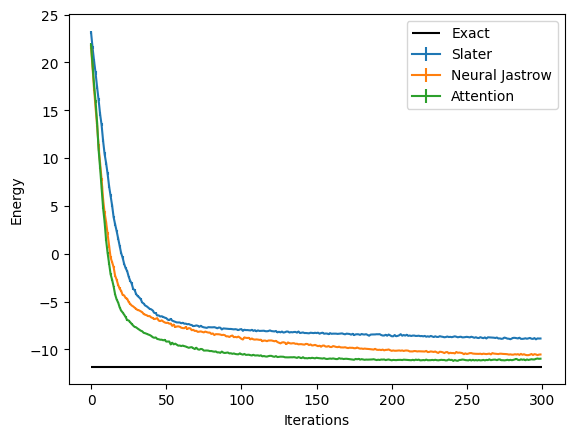

In [ ]:
logged_data = (slater_log.data, nj_log.data, atten_log.data)
labels = ("Slater","Neural Jastrow","Attention")

for data,label in zip(logged_data,labels):
    plt.errorbar(data["Energy"].iters, data["Energy"].Mean.real, yerr=data["Energy"].Sigma,label=label)

plt.hlines([E_gs], xmin=0, xmax=300, color='black', label="Exact")

plt.xlabel('Iterations')
plt.ylabel('Energy')
plt.legend()